# Лабораторная работа 5. Деревья решений.
## Нечетный вариант - оценки студентов.
## Раевский Григорий Романович, P3321


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("diabetes.csv", delimiter=',')
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### Визуализация данных

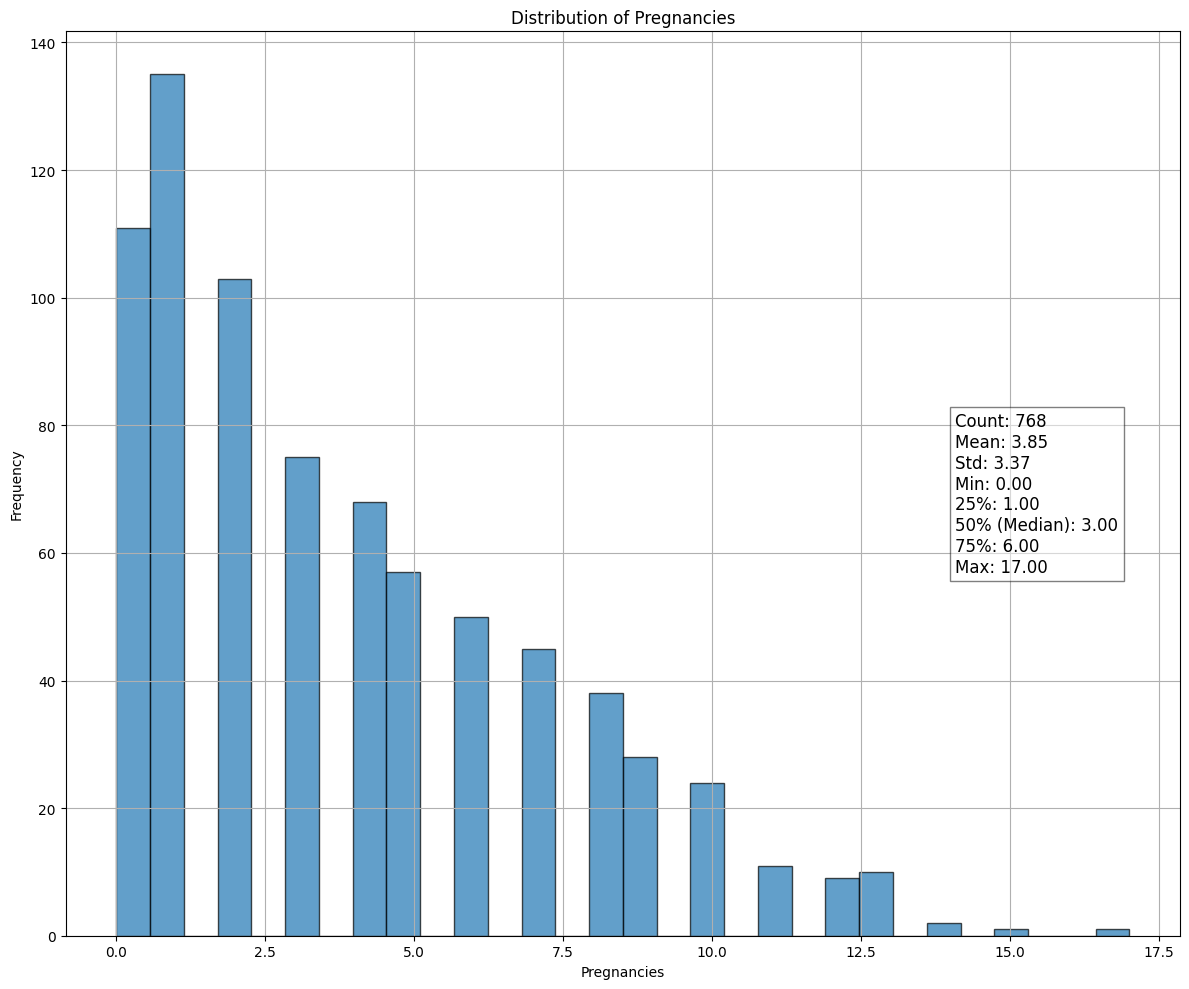

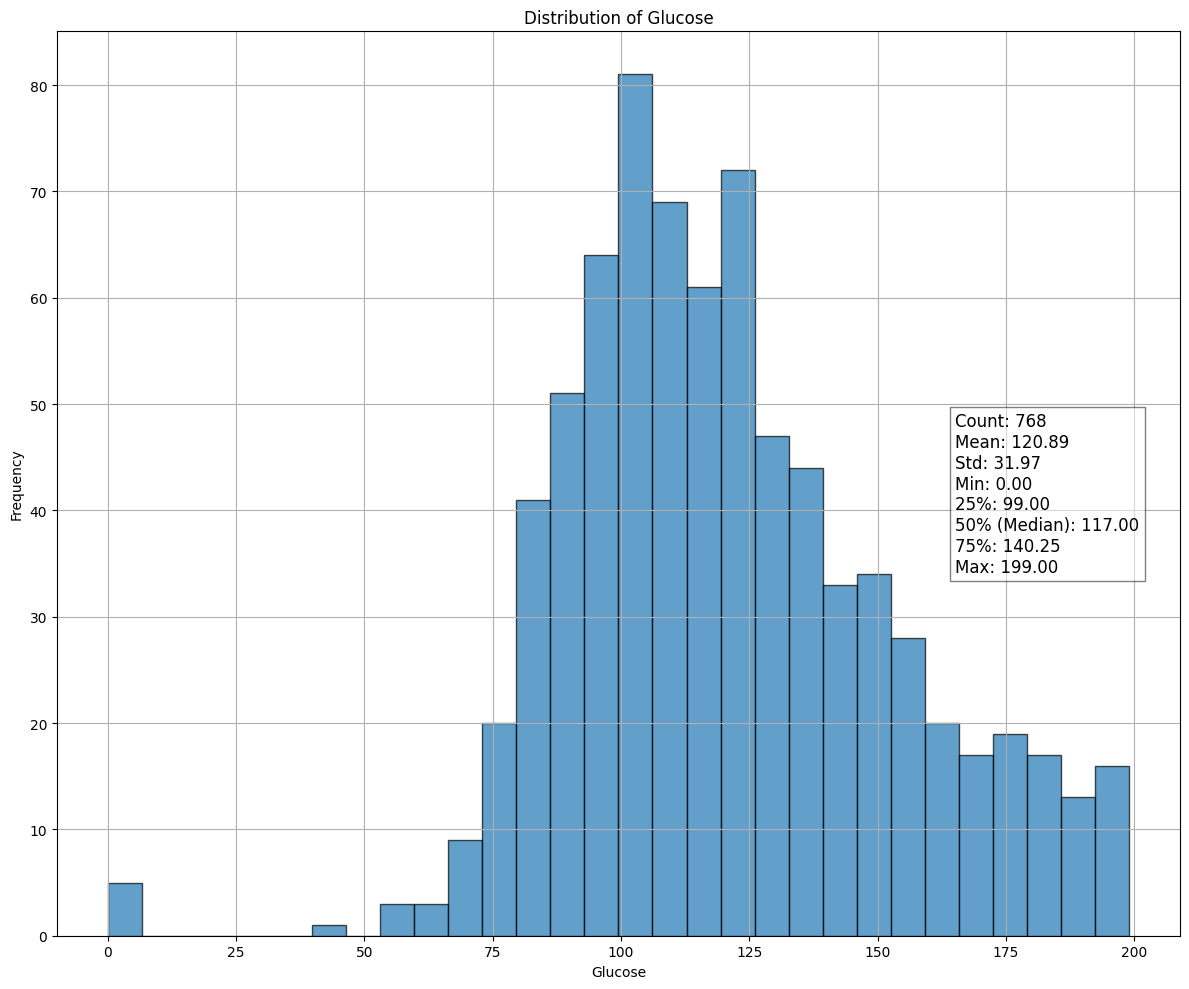

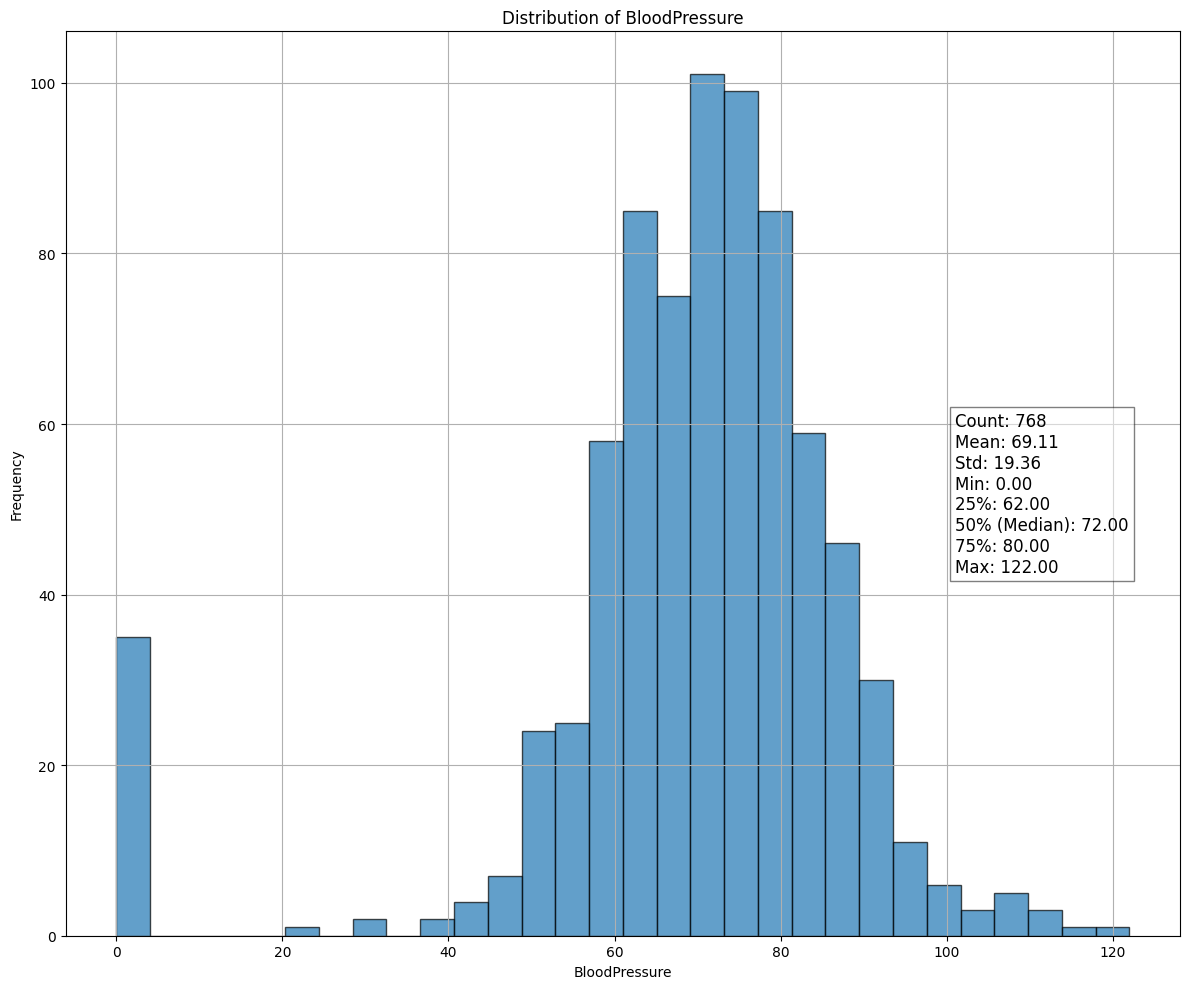

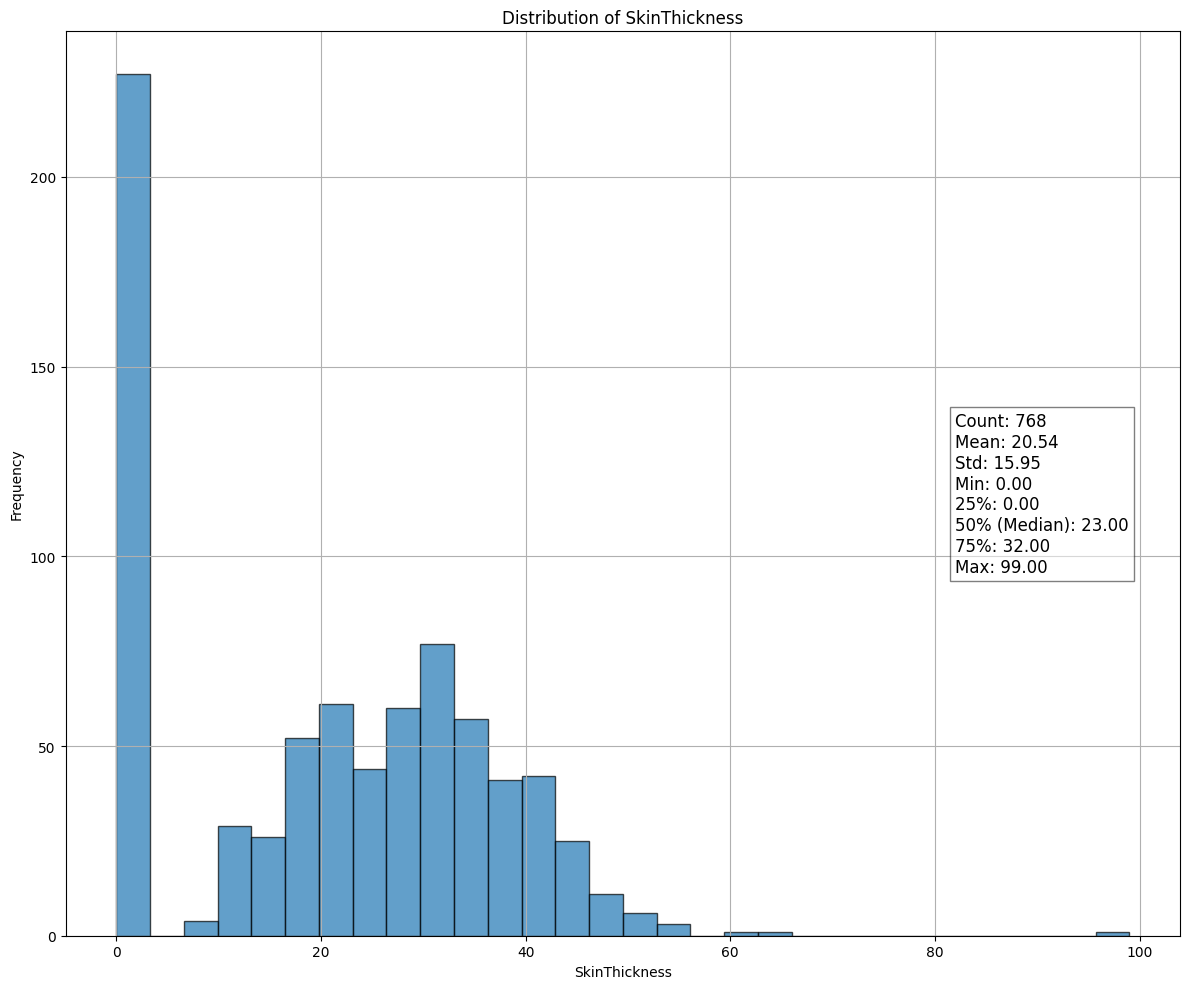

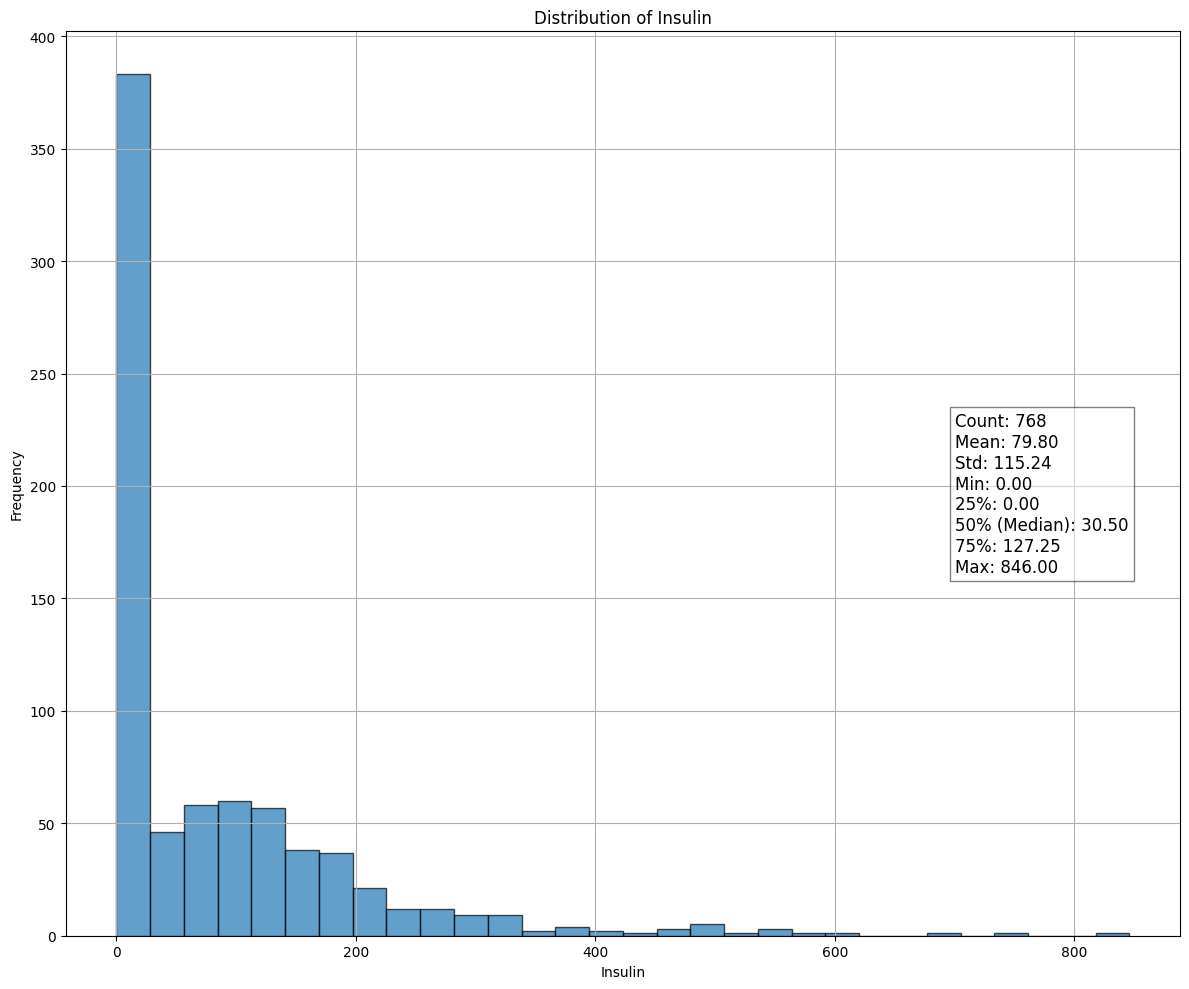

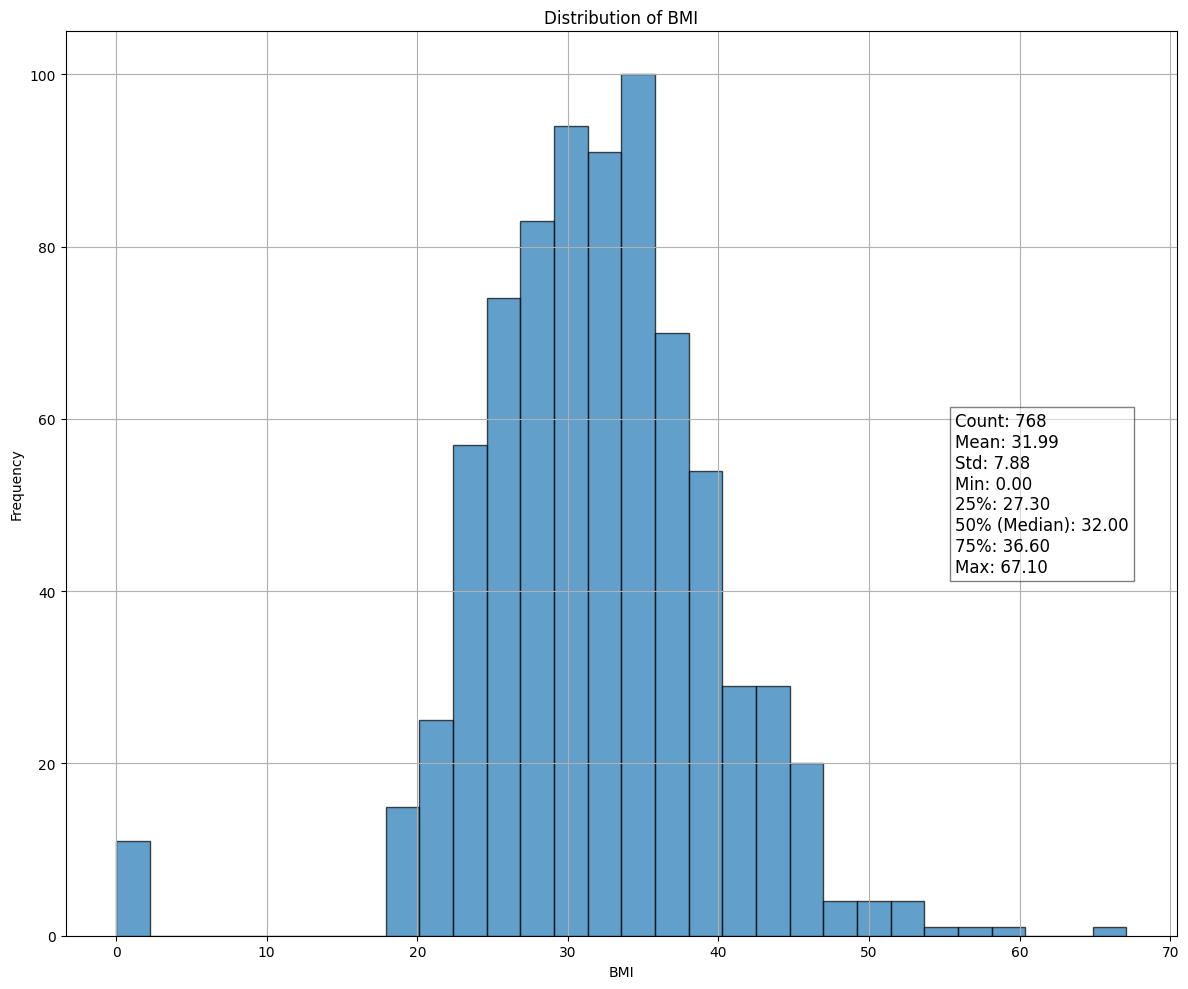

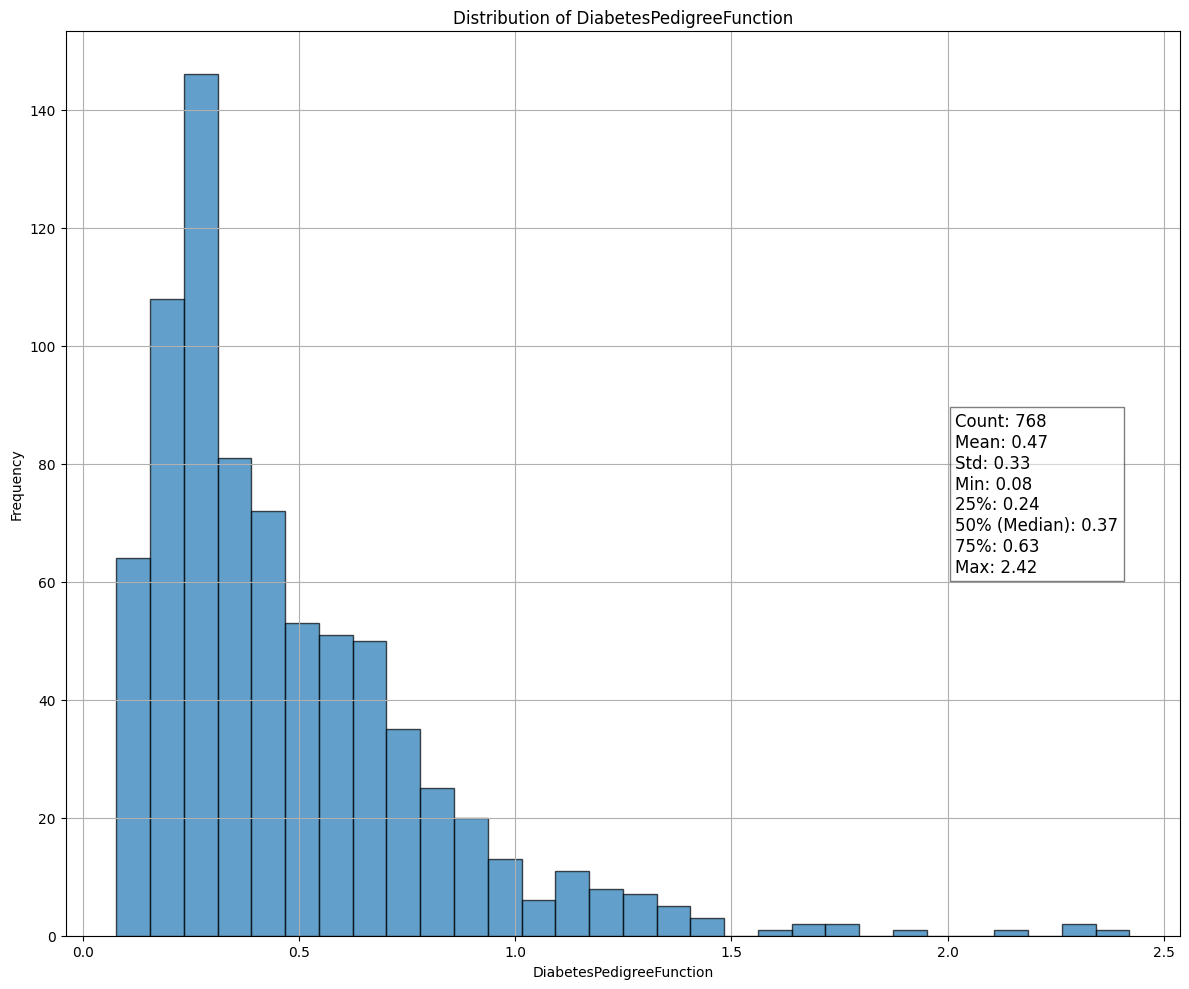

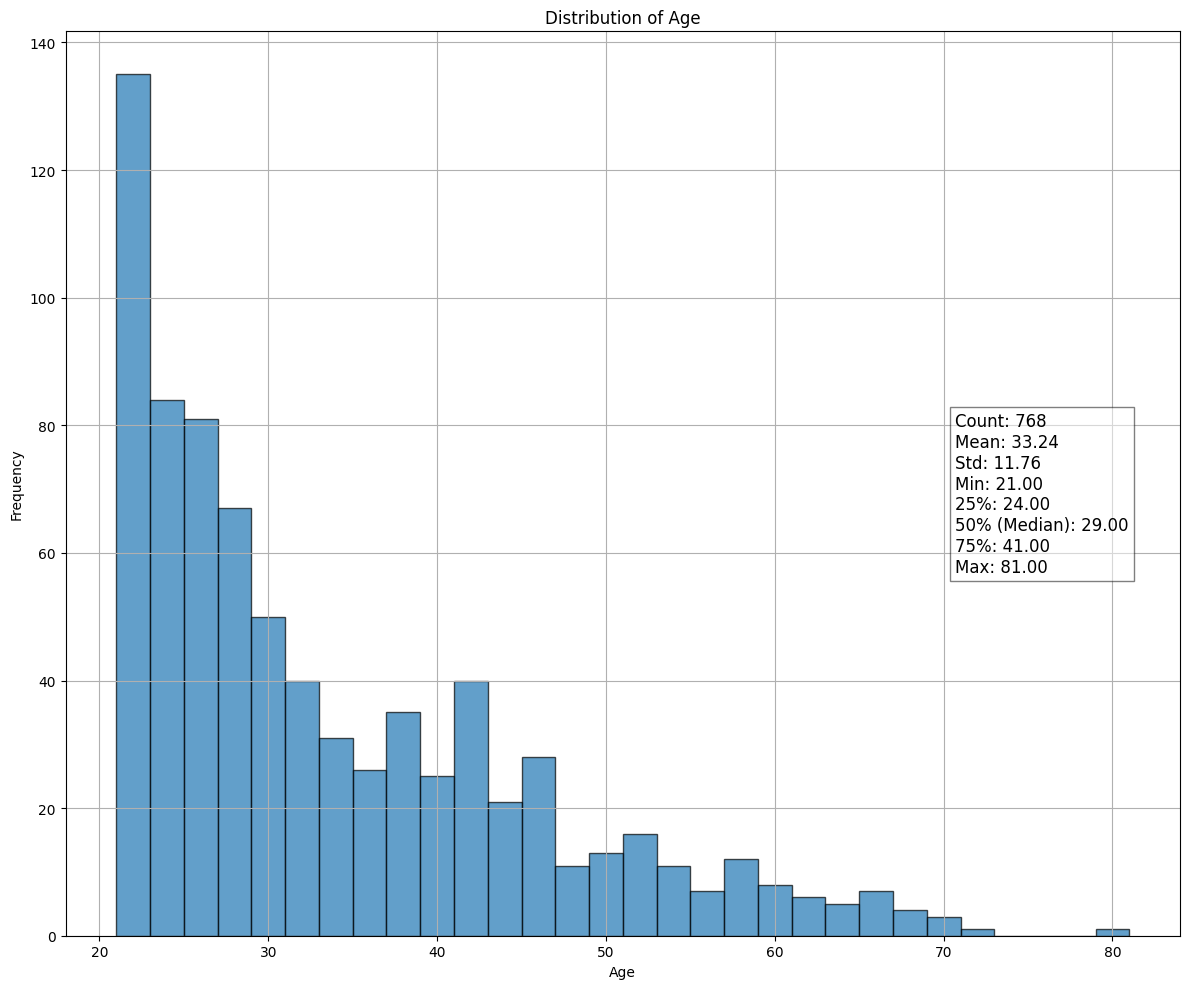

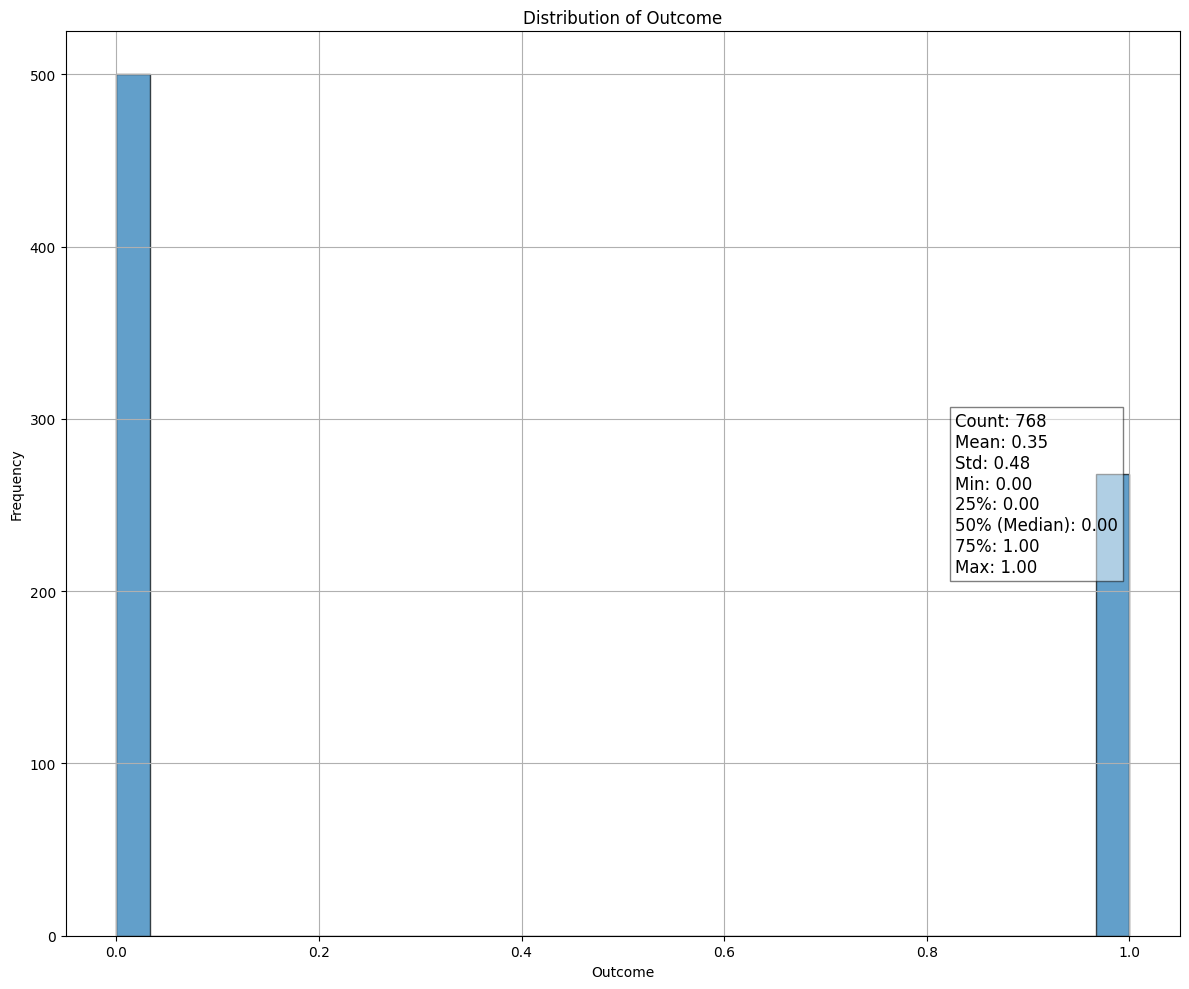

In [5]:
for column in data.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(12, 10))
    data[column].hist(bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    legend = (f'Count: {data[column].count()}\n'
              f'Mean: {data[column].mean():.2f}\n'
              f'Std: {data[column].std():.2f}\n'
              f'Min: {data[column].min():.2f}\n'
              f'25%: {data[column].quantile(0.25):.2f}\n'
              f'50% (Median): {data[column].median():.2f}\n'
              f'75%: {data[column].quantile(0.75):.2f}\n'
              f'Max: {data[column].max():.2f}')
    plt.gcf().text(0.8, 0.5, legend, fontsize=12, verticalalignment='center',
                   bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

### Обработка данных

In [6]:
data.isnull().sum() # Отсутсвующих значений нет

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
# no categorical

In [8]:
X = data.drop(columns=['Outcome'])
y = data['Outcome']

for column in X.columns:
    mean = X[column].mean()
    std = X[column].std()
    X[column] = (X[column] - mean) / std



### Разделение данных

In [9]:
test_size = 0.2
train_size = 1 - test_size

n_train = int(train_size * len(data))
indices = np.random.permutation(len(data))

train_indices = indices[:n_train]
test_indices = indices[n_train:]

X_train = X.iloc[train_indices].to_numpy()
X_test = X.iloc[test_indices].to_numpy()
y_train = y.iloc[train_indices].to_numpy()
y_test = y.iloc[test_indices].to_numpy()

### Логистическая регрессия

In [10]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=1000, method='gradient'):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.x0 = None
        self.method = method

    def f_sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def log_loss(self, y, y_pred):
        m = len(y)
        loss = -(1/m) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        return loss


    def learn(self, X, y):
        a, b = X.shape
        y = y.reshape(-1, 1)

        self.weights = np.zeros((b, 1))
        self.x0 = 0

        if self.method == 'gradient':
            # Градиентный спуск
            for epoch in range(self.epochs):
                y_pred = self.f_sigmoid(np.dot(X, self.weights) + self.x0)

                dz = y_pred - y
                dw = (1/a) * np.dot(X.T, dz)
                db = (1/a) * np.sum(dz)

                self.weights -= self.learning_rate * dw
                self.x0 -= self.learning_rate * db
        
        elif self.method == 'newton':
            # Метод Ньютона
            for epoch in range(self.epochs):
                y_pred = self.f_sigmoid(np.dot(X, self.weights) + self.x0)

                dz = y_pred - y
                dw = (1/a) * np.dot(X.T, dz)
                db = (1/a) * np.sum(dz)

                # Гессиан
                S = np.diag((y_pred * (1 - y_pred)).flatten())
                hessian = (1/a) * np.dot(np.dot(X.T, S), X)

                # Обратная матрица Гессиана
                hessian_inv = np.linalg.pinv(hessian)

                # Обновление весов
                self.weights -= np.dot(hessian_inv, dw)
                self.x0 -= db  # Сдвиг обновляется как в градиентном спуске



### Исследование гиперпараметров

In [11]:
def confusion_matrix(y_true, y_pred):
    cm = np.zeros((2, 2), dtype=int)
    for true, pred in zip(y_true, y_pred):
        cm[int(true), int(pred)] += 1
    return cm

def accuracy_score(cm):
    TP, TN, FP, FN = cm[1, 1], cm[0, 0], cm[0, 1], cm[1, 0]
    return (TP + TN) / (TP + TN + FP + FN)

def precision_score(cm):
    TP, TN, FP, FN = cm[1, 1], cm[0, 0], cm[0, 1], cm[1, 0]
    return TP/(TP+FP)

def recall_score(cm):
    TP, TN, FP, FN = cm[1, 1], cm[0, 0], cm[0, 1], cm[1, 0]
    return TP/(TP+FN)

def f1_score(cm):
    TP, TN, FP, FN = cm[1, 1], cm[0, 0], cm[0, 1], cm[1, 0]
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

In [12]:

def test_hyperparameters(X_train, y_train, X_test, y_test, learning_rates, epochs_list, method):
    results = []

    for lr in learning_rates:
        for epochs in epochs_list:

            model = LogisticRegression(learning_rate=lr, epochs=epochs, method=method)
            model.learn(X_train, y_train)
            
            y_pred = model.f_sigmoid(np.dot(X_test, model.weights) + model.x0)
            y_pred_binary = (y_pred >= 0.5).astype(int)

            cm = confusion_matrix(y_test, y_pred_binary)
            accuracy = accuracy_score(cm)
            precision = precision_score(cm)
            recall = recall_score(cm)
            loss = model.log_loss(y_test, y_pred)
            f1 = f1_score(cm)

            results.append({
                'method': method,
                'learning_rate': lr, 
                'epochs': epochs, 
                'loss': loss, 
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            })

    return pd.DataFrame(results)

learning_rates = [0.001, 0.01, 0.1, 0.5, 1]
epochs_list = [500, 1000, 2000, 5000]

results_gradient = test_hyperparameters(X_train, y_train, X_test, y_test, learning_rates, epochs_list, method='gradient')

results_newton = test_hyperparameters(X_train, y_train, X_test, y_test, learning_rates, epochs_list, method='newton')

# Объединяем результаты
results_df = pd.concat([results_gradient, results_newton])
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(results_df)

      method  learning_rate  epochs        loss  accuracy  precision    recall  f1_score
0   gradient          0.001     500  105.356886  0.753247   0.555556  0.681818  0.612245
1   gradient          0.001    1000  105.130748  0.740260   0.538462  0.636364  0.583333
2   gradient          0.001    2000  106.094898  0.740260   0.538462  0.636364  0.583333
3   gradient          0.001    5000  110.557432  0.740260   0.543478  0.568182  0.555556
4   gradient          0.010     500  110.568223  0.740260   0.543478  0.568182  0.555556
5   gradient          0.010    1000  115.988441  0.772727   0.609756  0.568182  0.588235
6   gradient          0.010    2000  122.119965  0.753247   0.575000  0.522727  0.547619
7   gradient          0.010    5000  127.539767  0.753247   0.575000  0.522727  0.547619
8   gradient          0.100     500  127.550830  0.753247   0.575000  0.522727  0.547619
9   gradient          0.100    1000  128.392368  0.753247   0.571429  0.545455  0.558140
10  gradient         